# TP1 - Mathematical Foundation and Step-by-Step Implementation
## Professor's Guide for Mobile Robotics Transformations

**Student**: [Your Name Here]  
**Course**: Robótica Móvel - DCC042  
**Objective**: Master spatial transformations and coordinate systems in robotics

---

## Part 1: Fundamental Mathematical Concepts

### Question for Reflection:
*Why do mobile robots need multiple coordinate systems? Think about this before proceeding.*

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# Set up plotting parameters for clear visualization
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Mathematical Foundation: Rotation Matrices

**Critical Understanding**: A rotation matrix $R_z(\theta)$ rotates a vector by angle $\theta$ around the z-axis.

$$R_z(\theta) = \begin{bmatrix}
\cos\theta & -\sin\theta & 0 \\
\sin\theta & \cos\theta & 0 \\
0 & 0 & 1
\end{bmatrix}$$

**Properties to Remember**:
1. $R^T = R^{-1}$ (orthogonal matrix)
2. $\det(R) = 1$ (proper rotation)
3. $R^T R = I$ (preserves lengths and angles)

In [3]:
def rotation_matrix_z(theta):
    """Create rotation matrix around z-axis

    Args:
        theta: rotation angle in radians

    Returns:
        3x3 rotation matrix
    """
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return np.array([
        [cos_theta, -sin_theta, 0],
        [sin_theta,  cos_theta, 0],
        [0,          0,         1]
    ])

def plot_coordinate_frame(origin, rotation_matrix, scale=1.0, colors=['red', 'green', 'blue'], labels=['X', 'Y', 'Z']):
    """Plot a coordinate frame with origin and orientation

    Args:
        origin: 3D position of frame origin
        rotation_matrix: 3x3 rotation matrix defining orientation
        scale: scale factor for axis vectors
        colors: colors for x, y, z axes
        labels: labels for axes
    """
    # Extract axis vectors from rotation matrix
    x_axis = rotation_matrix[:, 0] * scale
    y_axis = rotation_matrix[:, 1] * scale
    z_axis = rotation_matrix[:, 2] * scale

    # Plot 2D projection (x-y plane)
    plt.quiver(origin[0], origin[1], x_axis[0], x_axis[1],
               color=colors[0], angles='xy', scale_units='xy', scale=1, width=0.005)
    plt.quiver(origin[0], origin[1], y_axis[0], y_axis[1],
               color=colors[1], angles='xy', scale_units='xy', scale=1, width=0.005)

    # Add labels
    plt.text(origin[0] + x_axis[0]*1.1, origin[1] + x_axis[1]*1.1, labels[0], color=colors[0], fontweight='bold')
    plt.text(origin[0] + y_axis[0]*1.1, origin[1] + y_axis[1]*1.1, labels[1], color=colors[1], fontweight='bold')

# Test the rotation matrix properties
theta = np.pi/4  # 45 degrees
R = rotation_matrix_z(theta)

print("Rotation Matrix R_z(45°):")
print(R)
print(f"\nDeterminant: {np.linalg.det(R):.6f} (should be 1.0)")
print(f"R^T * R = I? {np.allclose(R.T @ R, np.eye(3))}")

Rotation Matrix R_z(45°):
[[ 0.70710678 -0.70710678  0.        ]
 [ 0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]

Determinant: 1.000000 (should be 1.0)
R^T * R = I? True


## Homogeneous Transformations: The Key to TP1

**Why Homogeneous Coordinates?**
- Combine rotation AND translation in a single matrix operation
- Compose multiple transformations easily
- Essential for robotics coordinate transformations

$$T = \begin{bmatrix}
R & t \\
0^T & 1
\end{bmatrix} = \begin{bmatrix}
r_{11} & r_{12} & r_{13} & t_x \\
r_{21} & r_{22} & r_{23} & t_y \\
r_{31} & r_{32} & r_{33} & t_z \\
0 & 0 & 0 & 1
\end{bmatrix}$$

**Key Property**: $p_{global} = T_{local \rightarrow global} \cdot p_{local}$

In [4]:
def homogeneous_transform(rotation_matrix, translation_vector):
    """Create 4x4 homogeneous transformation matrix

    Args:
        rotation_matrix: 3x3 rotation matrix
        translation_vector: 3D translation vector

    Returns:
        4x4 homogeneous transformation matrix
    """
    T = np.eye(4)
    T[0:3, 0:3] = rotation_matrix
    T[0:3, 3] = translation_vector
    return T

def inverse_transform(T):
    """Compute inverse of homogeneous transformation

    For T = [R t; 0 1], T^-1 = [R^T -R^T*t; 0 1]
    """
    R = T[0:3, 0:3]
    t = T[0:3, 3]

    T_inv = np.eye(4)
    T_inv[0:3, 0:3] = R.T
    T_inv[0:3, 3] = -R.T @ t
    return T_inv

# Example: Robot at (5, 3) with 30° orientation
robot_position = np.array([5, 3, 0])
robot_orientation = np.deg2rad(30)  # 30 degrees

R_robot = rotation_matrix_z(robot_orientation)
T_world_to_robot = homogeneous_transform(R_robot, robot_position)

print("Transformation from World to Robot frame:")
print(T_world_to_robot)

# Verify inverse property
T_inverse = inverse_transform(T_world_to_robot)
identity_check = T_world_to_robot @ T_inverse
print(f"\nT * T^-1 = I? {np.allclose(identity_check, np.eye(4))}")

Transformation from World to Robot frame:
[[ 0.8660254 -0.5        0.         5.       ]
 [ 0.5        0.8660254  0.         3.       ]
 [ 0.         0.         1.         0.       ]
 [ 0.         0.         0.         1.       ]]

T * T^-1 = I? True


## TP1 Exercise 3: Transform Objects to Robot Frame

**Mathematical Challenge**: Given robot configuration $q = [x, y, \theta]$ and object positions in global frame, find object positions in robot's local frame.

**Steps**:
1. Create transformation matrix $T_{world \rightarrow robot}$
2. Compute inverse: $T_{robot \rightarrow world}^{-1}$
3. Transform: $p_{robot} = T_{robot \rightarrow world}^{-1} \cdot p_{world}$

In [5]:
def robot_to_world_transform(x, y, theta):
    """Create transformation from robot frame to world frame

    Args:
        x, y: robot position in world frame
        theta: robot orientation in world frame (radians)

    Returns:
        4x4 transformation matrix
    """
    R = rotation_matrix_z(theta)
    t = np.array([x, y, 0])
    return homogeneous_transform(R, t)

def transform_objects_to_robot_frame(robot_config, object_positions):
    """Transform multiple objects from world to robot frame

    Args:
        robot_config: [x, y, theta] robot configuration
        object_positions: list of [x, y, z] object positions in world frame

    Returns:
        list of object positions in robot frame
    """
    x, y, theta = robot_config

    # Get transformation from robot to world
    T_robot_to_world = robot_to_world_transform(x, y, theta)

    # Inverse gives us world to robot transformation
    T_world_to_robot = inverse_transform(T_robot_to_world)

    robot_frame_objects = []

    for obj_pos in object_positions:
        # Convert to homogeneous coordinates
        obj_homogeneous = np.array([obj_pos[0], obj_pos[1], obj_pos[2] if len(obj_pos) > 2 else 0, 1])

        # Transform to robot frame
        obj_robot_frame = T_world_to_robot @ obj_homogeneous

        robot_frame_objects.append(obj_robot_frame[0:3])  # Remove homogeneous coordinate

    return robot_frame_objects, T_world_to_robot

# Example scenario for TP1
print("=== TP1 Example Scenario ===")

# Robot configuration: x=3, y=2, theta=45°
robot_config = [3, 2, np.deg2rad(45)]

# Five different objects in the scene (global coordinates)
objects_global = [
    [6, 5, 0],    # Object 1: furniture
    [1, 4, 0],    # Object 2: person
    [8, 1, 0],    # Object 3: another robot
    [0, 0, 0],    # Object 4: origin marker
    [5, 7, 0]     # Object 5: wall
]

# Transform to robot frame
objects_robot, T_transform = transform_objects_to_robot_frame(robot_config, objects_global)

print(f"Robot configuration: x={robot_config[0]}, y={robot_config[1]}, θ={np.rad2deg(robot_config[2]):.1f}°")
print("\nTransformation Matrix (World → Robot):")
print(T_transform)

print("\nObject positions:")
for i, (global_pos, robot_pos) in enumerate(zip(objects_global, objects_robot)):
    print(f"Object {i+1}: Global {global_pos} → Robot [{robot_pos[0]:.2f}, {robot_pos[1]:.2f}, {robot_pos[2]:.2f}]")

=== TP1 Example Scenario ===
Robot configuration: x=3, y=2, θ=45.0°

Transformation Matrix (World → Robot):
[[ 0.70710678  0.70710678  0.         -3.53553391]
 [-0.70710678  0.70710678  0.          0.70710678]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]

Object positions:
Object 1: Global [6, 5, 0] → Robot [4.24, 0.00, 0.00]
Object 2: Global [1, 4, 0] → Robot [-0.00, 2.83, 0.00]
Object 3: Global [8, 1, 0] → Robot [2.83, -4.24, 0.00]
Object 4: Global [0, 0, 0] → Robot [-3.54, 0.71, 0.00]
Object 5: Global [5, 7, 0] → Robot [4.95, 2.12, 0.00]


## Visualization: Understanding the Transformations

**Critical for TP1**: You must visualize coordinate frames and relationships!

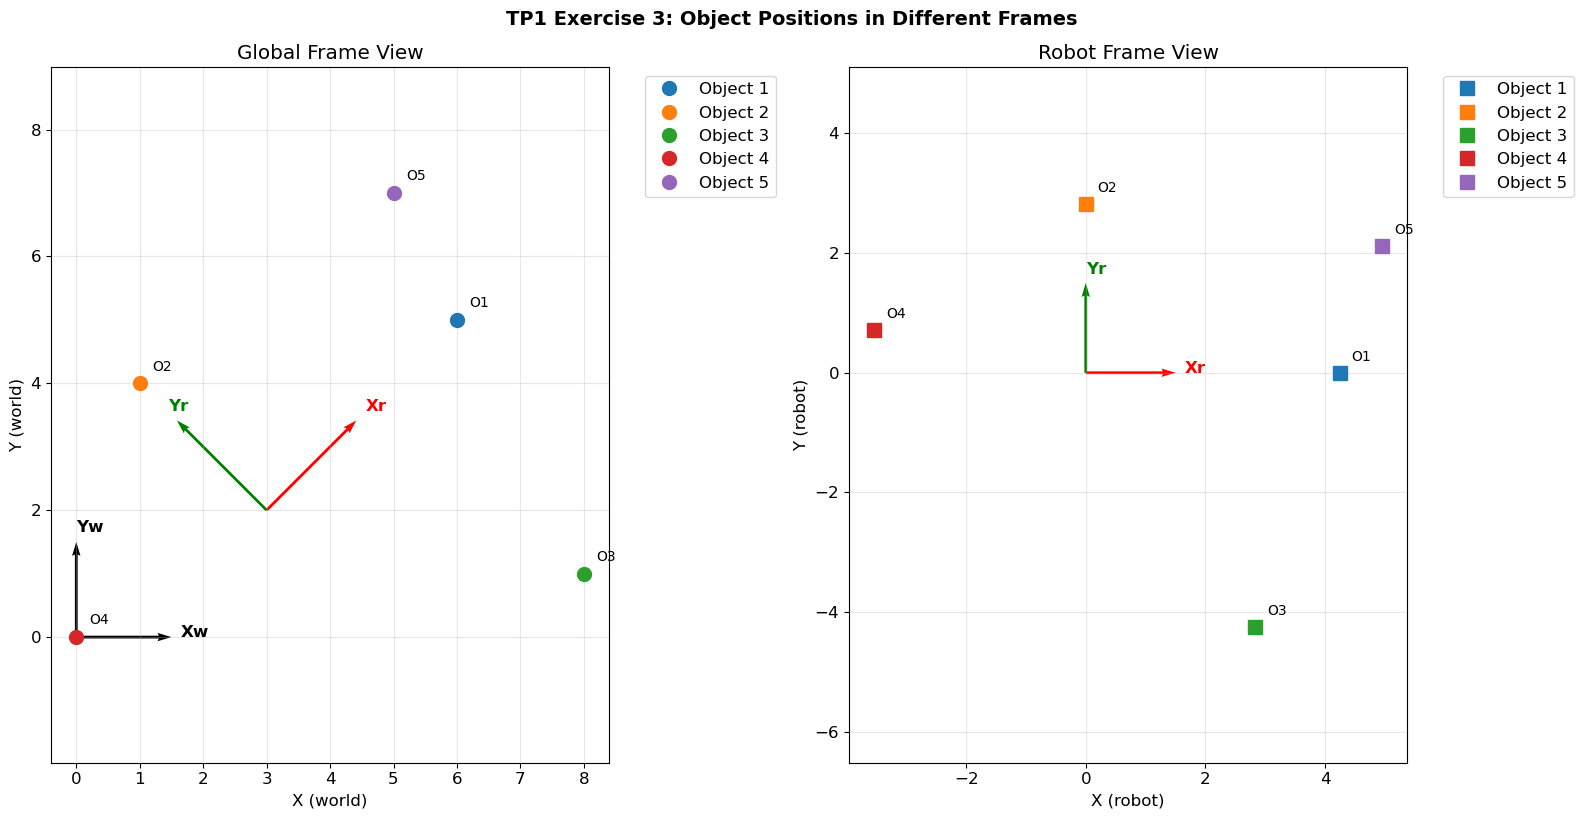

In [6]:
def plot_scenario(robot_config, objects_global, objects_robot, title="Coordinate Transformation Visualization"):
    """Plot both global and robot-centric views"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Plot 1: Global view
    plt.sca(ax1)

    # Plot world frame
    world_origin = np.array([0, 0, 0])
    world_rotation = np.eye(3)
    plot_coordinate_frame(world_origin, world_rotation, scale=1.5,
                         colors=['black', 'black', 'black'], labels=['Xw', 'Yw', 'Zw'])

    # Plot robot frame
    robot_origin = np.array([robot_config[0], robot_config[1], 0])
    robot_rotation = rotation_matrix_z(robot_config[2])
    plot_coordinate_frame(robot_origin, robot_rotation, scale=2.0,
                         colors=['red', 'green', 'blue'], labels=['Xr', 'Yr', 'Zr'])

    # Plot objects in global frame
    for i, obj in enumerate(objects_global):
        plt.plot(obj[0], obj[1], 'o', markersize=10, label=f'Object {i+1}')
        plt.text(obj[0]+0.2, obj[1]+0.2, f'O{i+1}', fontsize=10)

    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.title('Global Frame View')
    plt.xlabel('X (world)')
    plt.ylabel('Y (world)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot 2: Robot-centric view
    plt.sca(ax2)

    # Robot frame at origin
    robot_local_origin = np.array([0, 0, 0])
    robot_local_rotation = np.eye(3)
    plot_coordinate_frame(robot_local_origin, robot_local_rotation, scale=1.5,
                         colors=['red', 'green', 'blue'], labels=['Xr', 'Yr', 'Zr'])

    # Plot objects in robot frame
    for i, obj in enumerate(objects_robot):
        plt.plot(obj[0], obj[1], 's', markersize=10, label=f'Object {i+1}')
        plt.text(obj[0]+0.2, obj[1]+0.2, f'O{i+1}', fontsize=10)

    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.title('Robot Frame View')
    plt.xlabel('X (robot)')
    plt.ylabel('Y (robot)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.suptitle(title, y=1.02, fontsize=14, fontweight='bold')
    plt.show()

# Visualize the transformation
plot_scenario(robot_config, objects_global, objects_robot,
              "TP1 Exercise 3: Object Positions in Different Frames")

## Critical Thinking Questions for You:

1. **Verification**: How can you verify your transformation is correct?
2. **Inverse Test**: If you transform back from robot to world frame, do you get the original coordinates?
3. **Physical Meaning**: What does a negative X coordinate in robot frame mean physically?
4. **Edge Cases**: What happens when the robot orientation is 0°? 90°? 180°?

**Exercise for You**: Work out one transformation by hand before using the code!

In [ ]:
# Exercise 4: Different robot positions
print("=== TP1 Exercise 4: Different Robot Positions ===")

# Three different robot configurations
robot_configs = [
    [2, 1, np.deg2rad(0)],    # Facing forward
    [6, 4, np.deg2rad(90)],   # Facing left
    [4, 6, np.deg2rad(180)]   # Facing backward
]

# Same objects in all scenarios
objects_global = [
    [5, 3, 0],    # Object 1
    [2, 5, 0],    # Object 2
    [7, 2, 0],    # Object 3
    [1, 1, 0],    # Object 4
    [8, 6, 0]     # Object 5
]

for i, config in enumerate(robot_configs):
    print(f"\n--- Robot Position {i+1} ---")
    objects_robot, T = transform_objects_to_robot_frame(config, objects_global)

    print(f"Robot: x={config[0]}, y={config[1]}, θ={np.rad2deg(config[2]):.0f}°")
    for j, (global_pos, robot_pos) in enumerate(zip(objects_global, objects_robot)):
        print(f"  Object {j+1}: [{robot_pos[0]:.2f}, {robot_pos[1]:.2f}]")

    # Plot each scenario
    plot_scenario(config, objects_global, objects_robot,
                  f"Robot Position {i+1}: θ={np.rad2deg(config[2]):.0f}°")

## Next Steps for Your TP1:

### Exercise 5: Laser Sensor Transformations
You'll need to understand **composition of transformations**:
- $T_{world}^{laser} = T_{world}^{robot} \cdot T_{robot}^{laser}$

### Exercise 6: Path Integration
You'll need to:
- Store robot poses over time
- Transform laser readings at each pose
- Combine all readings in global frame

## Key Implementation Tips:
1. **Always verify** your math with simple test cases
2. **Visualize everything** - if you can't see it, you probably don't understand it
3. **Test edge cases** - what happens at θ=0°, 90°, 180°?
4. **Check inverse transformations** - can you get back to where you started?

## Professor's Challenge:
Before implementing in CoppeliaSim, solve this by hand:
- Robot at (2,3) oriented 60°
- Object at (5,1) in world frame
- What's the object position in robot frame?

**Work this out step by step with pen and paper first!**